# Importances and Coefficients

#### By: Ahmed Fathi

## Importing libraries

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib, os

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

## Importing Sales Data


In [2]:
url = ('https://docs.google.com/spreadsheets/d/e/2PACX-1vT7T4OEvxCrrx8SNk2CNc9yyApd4S8_rhhT2p2zqCeptIaPmGiSlh-bKDDYQ6beipefWAOvzlb_glAe/pub?output=csv')
df = pd.read_csv(url)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
# drop null values ONLY FROM TARGET
df = df.dropna(subset=['Item_Outlet_Sales'])

In [4]:
df = df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)


In [5]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


## Preprocessing

In [6]:
# Train Test Split
# Make x and y variables
target = 'Item_Outlet_Sales'
drop_feats = []

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

# Train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED)
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,1998,NaN,Tier 3,Grocery Store
7604,6.135,LF,0.079294,Soft Drinks,111.2860,2009,Medium,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,2004,Small,Tier 2,Supermarket Type1


In [7]:
# Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

In [8]:
nom_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), OneHotEncoder(handle_unknown='ignore', sparse=False))
nom_sel = ['Item_Fat_Content', 'Item_Type', 'Outlet_Establishment_Year', 'Outlet_Location_Type', 'Outlet_Type']

In [9]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (nom_pipe,nom_sel),)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x124567460>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Establishment_Year',
                                  'Outlet_Location_Type', 'Outlet_Type'])])

In [10]:
# Make X_train_df and X_test_df, dataframe verisons of processed X_train/X_test
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

,pipeline-1__Item_Weight,pipeline-1__Item_Visibility,pipeline-1__Item_MRP,pipeline-1__Outlet_Establishment_Year,pipeline-2__Item_Fat_Content_LF,pipeline-2__Item_Fat_Content_Low Fat,pipeline-2__Item_Fat_Content_Regular,pipeline-2__Item_Fat_Content_low fat,pipeline-2__Item_Fat_Content_reg,pipeline-2__Item_Type_Baking Goods,...,pipeline-2__Outlet_Establishment_Year_2004,pipeline-2__Outlet_Establishment_Year_2007,pipeline-2__Outlet_Establishment_Year_2009,pipeline-2__Outlet_Location_Type_Tier 1,pipeline-2__Outlet_Location_Type_Tier 2,pipeline-2__Outlet_Location_Type_Tier 3,pipeline-2__Outlet_Type_Grocery Store,pipeline-2__Outlet_Type_Supermarket Type1,pipeline-2__Outlet_Type_Supermarket Type2,pipeline-2__Outlet_Type_Supermarket Type3
8269,7.220000,0.064142,61.2510,1998.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7604,6.135000,0.079294,111.2860,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2762,12.150000,0.028593,151.0708,2004.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6464,5.945000,0.093009,127.8652,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4707,18.200000,0.066285,247.2092,2004.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,12.822634,0.012216,162.7894,1985.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8360,11.500000,0.014884,174.5080,1999.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5929,5.110000,0.034945,161.1210,2002.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4220,6.550000,0.034800,157.5288,2007.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Getting Features Names + Verbose Feature Names Out

In [11]:
# Make the preprocessing column transformer WITH CORRECT ARGS!
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (nom_pipe, nom_sel),
                                      verbose_feature_names_out=False)
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.220000,0.064142,61.2510,1998.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7604,6.135000,0.079294,111.2860,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2762,12.150000,0.028593,151.0708,2004.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6464,5.945000,0.093009,127.8652,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4707,18.200000,0.066285,247.2092,2004.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,12.822634,0.012216,162.7894,1985.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8360,11.500000,0.014884,174.5080,1999.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5929,5.110000,0.034945,161.1210,2002.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4220,6.550000,0.034800,157.5288,2007.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Modeling with LinearRegression

In [12]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [13]:
# Model for LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,826.82,"1,114.87"
Test,0.56,860.19,"1,164.39"


## Extracting and visualizing coefficients

### Extracting

In [14]:
# Defining a function to get the coefficients
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [15]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                           1.094575
Item_Visibility                    -279.839968
Item_MRP                             15.597465
Outlet_Establishment_Year            -1.192420
Item_Fat_Content_LF                 -27.897570
Item_Fat_Content_Low Fat              4.991544
Item_Fat_Content_Regular             40.125388
Item_Fat_Content_low fat             59.052031
Item_Fat_Content_reg                -76.271393
Item_Type_Baking Goods                9.470694
Item_Type_Breads                     -6.188674
Item_Type_Breakfast                  68.448349
Item_Type_Canned                     22.166314
Item_Type_Dairy                     -49.395163
Item_Type_Frozen Foods               -4.439583
Item_Type_Fruits and Vegetables      16.573827
Item_Type_Hard Drinks                48.715186
Item_Type_Health and Hygiene        -41.377764
Item_Type_Household                 -68.673159
Item_Type_Meat                      -15.681236
Item_Type_Others                     18.938012
Item_Type_Sea

In [16]:
# Formatting numbers
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [17]:
coeffs.sort_values()

Outlet_Type_Grocery Store         -1,442.1189
Outlet_Establishment_Year_1998      -450.9620
Outlet_Location_Type_Tier 1         -331.4459
Outlet_Establishment_Year_1987      -312.7100
Item_Visibility                     -279.8400
Outlet_Establishment_Year_2002      -134.1763
Outlet_Type_Supermarket Type2       -123.2811
Outlet_Establishment_Year_2009      -123.2811
Item_Type_Soft Drinks               -117.1952
Item_Fat_Content_reg                 -76.2714
Item_Type_Household                  -68.6732
Item_Type_Dairy                      -49.3952
Item_Type_Health and Hygiene         -41.3778
Item_Fat_Content_LF                  -27.8976
Item_Type_Meat                       -15.6812
Item_Type_Snack Foods                -11.4824
Item_Type_Breads                      -6.1887
Item_Type_Frozen Foods                -4.4396
Outlet_Establishment_Year             -1.1924
Item_Weight                            1.0946
Item_Fat_Content_Low Fat               4.9915
Item_Type_Baking Goods            

## Visualizing the coefficients

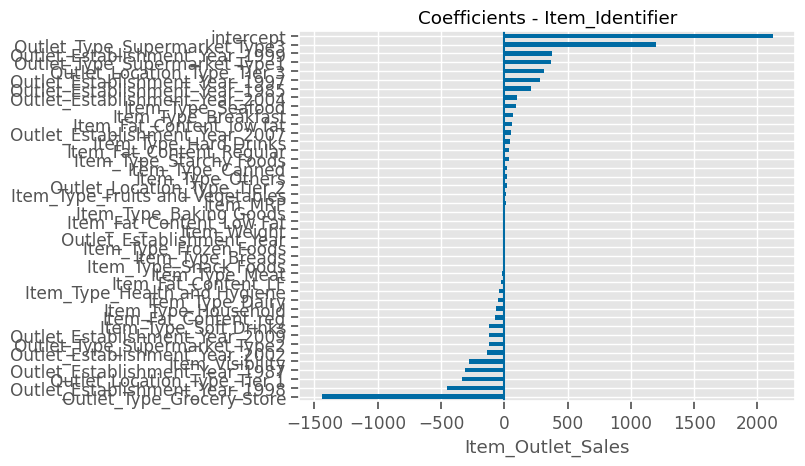

In [18]:
# Plotting everything except for Item_Identifier
ax = coeffs.sort_values().plot(kind='barh')#, figsize=(8,25))
ax.axvline(0)
ax.set(xlabel='Item_Outlet_Sales', title="Coefficients - Item_Identifier");
plt.savefig('LinearRegression_Plot.png')

In [19]:
# Saving the visualization


#### The top 3 Coefficients that the LinearRegression model shows to be impactful are Outlet_Type_Supermarket_type_3, Outlet_Establishment_year_1999, and Outlet_Type_Supermarket_type_1 based on the fact that they are the 3 that have the highest impact on Item_Outlet_Sales based on the graphic.

## Modeling with RandomForest

In [20]:
def plot_coefficients_simple(coeffs, sort_values=True, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart"""
    if sort_values:
        coeffs = coeffs.sort_values()
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [21]:
def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [22]:
# Model for RandomForest
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,292.70,423.61
Test,0.56,818.88,"1,168.49"


In [23]:
## Saving the coefficients
def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances

importances = get_importances(rf_reg)
importances

Item_Weight                       0.0514
Item_Visibility                   0.0962
Item_MRP                          0.4424
Outlet_Establishment_Year         0.0284
Item_Fat_Content_LF               0.0031
Item_Fat_Content_Low Fat          0.0061
Item_Fat_Content_Regular          0.0056
Item_Fat_Content_low fat          0.0015
Item_Fat_Content_reg              0.0016
Item_Type_Baking Goods            0.0045
Item_Type_Breads                  0.0027
Item_Type_Breakfast               0.0025
Item_Type_Canned                  0.0043
Item_Type_Dairy                   0.0056
Item_Type_Frozen Foods            0.0057
Item_Type_Fruits and Vegetables   0.0081
Item_Type_Hard Drinks             0.0028
Item_Type_Health and Hygiene      0.0041
Item_Type_Household               0.0061
Item_Type_Meat                    0.0035
Item_Type_Others                  0.0015
Item_Type_Seafood                 0.0013
Item_Type_Snack Foods             0.0082
Item_Type_Soft Drinks             0.0042
Item_Type_Starch

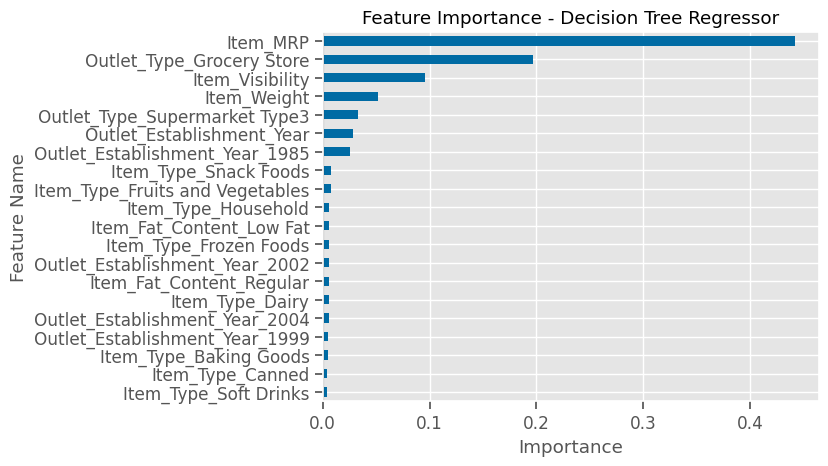

In [24]:
ax = importances.sort_values().tail(20).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');
plt.savefig('RandomForest_Plot.png')

In [25]:
# Saving the visualization


#### Based on our RandomForest model, the top 5 features are:
- Item_MRP
- Outlet_Type_Grocery Store
- Item_Visibilty
- Item_Weight
- Outlet_Type_supermarket Type 3

## Using joblib to Save our Model, Data, and Objects

In [26]:
# Creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg
         }

In [27]:
folder = "Models/"
os.makedirs(folder, exist_ok=True)

In [28]:
fname = folder+'best-models.joblib'
joblib.dump(export, fname)

['Models/best-models.joblib']